In [1]:
import torch
import torchvision
import einops

from torch import nn
from IPython.display import display

pil = torchvision.transforms.ToPILImage()

device = "cuda"

loading the RAF-DB dataset

In [2]:
import os
from PIL import Image

from torchvision import transforms
from torch.utils.data import Dataset


class RAFDB(Dataset):
    labels_num2str = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Neutral"]
    labels_str2num = {v: k for k, v in enumerate(labels_num2str)}

    def __init__(
        self,
        path: str,
        mode: str,
        transform=transforms.Compose(
            (
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            )
        ),
    ):
        self._label_map = dict()
        with open(os.path.join(path, "EmoLabel", "list_patition_label.txt")) as f:
            for line in f.read().splitlines():
                filename, label = line.split(" ")
                label = int(label) - 1
                self._label_map[filename.split(".")[0]] = label

        img_dir = os.path.join(path, "Image", "aligned")
        self._image_paths = []
        for image_name in os.listdir(img_dir):
            if image_name.startswith(mode):
                self._image_paths.append(os.path.join(img_dir, image_name))

        self._transform = transform

    def __getitem__(self, idx):
        image_path = self._image_paths[idx]
        image_name = "_".join(os.path.split(image_path)[1].split("_")[:2])
        label = self._label_map[image_name]
        data = Image.open(image_path)
        data = self._transform(data)
        return data, label

    def __len__(self):
        return len(self._image_paths)


In [3]:
dataset_path = r"D:\学习\大学\大创\王艳\RAF-DB"

train_set = RAFDB(dataset_path, "train")
test_set = RAFDB(dataset_path, "test")

torch.Size([3, 100, 100])

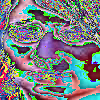

4

In [4]:
image = train_set[0][0]
display(image.shape)
display(pil(image))
display(train_set[0][1])

In [5]:
from einops.layers.torch import Rearrange


class VisionTransformer(nn.Module):
    def __init__(self, image_shape, width_patch_num, height_patch_num, d_model, n_head, dim_feedforward, encoder_num):
        '''
        the shape of the image should be: (channels, width, height)
        image_shape[-2] should be divisible by width_patch_num
        image_shape[-1] should be divisible by height_patch_num
        d_model is the dimension of embedding vector feeding to the transformer
        nhead is the number of heads in multi-head-self-attension module, d_model should be devisible by it
        dim_feedforward is the dimension of the hidden layer in feed-forward module
        encoder_num is the number of transformer encoders
        '''
        super().__init__()

        if image_shape[-2] % width_patch_num != 0:
            raise Exception(f"width_patch_num({width_patch_num}) is not devisible by image_shape[-2]({image_shape[-2]})")
        if image_shape[-1] % height_patch_num != 0:
            raise Exception(f"height_patch_num({height_patch_num}) is not devisible by image_shape[-1]({image_shape[-1]})")
        if d_model % n_head != 0:
            raise Exception(f"d_model({d_model}) is not devisible by n_head({n_head})")
        
        patch_width = image_shape[-2] // width_patch_num
        patch_height = image_shape[-1] // height_patch_num

        # assuming hpn=20, wpn=20, d_model=64
        # shape: (batch, 3, 100, 100) == (batch, 3*20*20, 5*5) -> (batch, 3*20*20, 64)
        self.patch_embedding = nn.Sequential(
            Rearrange("b c (wpn pw) (hpn ph) -> b (c wpn hpn) (pw ph)", wpn=width_patch_num, hpn=height_patch_num),
            nn.Linear(patch_width * patch_height, d_model),
        )
        # shape: (batch, 3*20*20+1, 64)
        self.class_token = nn.parameter.Parameter(torch.randn((1, 1, d_model)))
        # shape: same
        self.position_encodings = nn.parameter.Parameter(
            torch.randn((1, image_shape[-3] * width_patch_num * height_patch_num + 1, d_model))
        )
        # the actual transformer, we use the transformer provided by pytorch here.
        # d_model is the dimention for the embedding vector
        # n_head is the number of heads in the multi head self attention thing
        # d_model has to be divisible by n_head
        # dim_feedforward is the number of hidden nodes in hidden layer in feedforward block
        # batch_first means the first dim of the tensor is batch
        # shape: same
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_head, dim_feedforward=dim_feedforward, batch_first=True
            ),
            encoder_num,
        )
        # the final MLP
        # shape: (batch, 3*20*20+1, 64) -> (batch, 10)
        self.mlp_head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 10))

    def forward(self, x):
        x = self.patch_embedding(x)
        batch_size, _, _ = x.shape
        class_token = einops.repeat(
            self.class_token,
            "() words features -> repeat words features",
            repeat=batch_size,
        )
        x = torch.cat((class_token, x), dim=-2)
        x += self.position_encodings
        x = self.transformer_encoder(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

Code copied from lucidrains/vit-pytorch repo:

In [6]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [7]:
# model = VisionTransformer(
#     image_shape=(3, 100, 100),
#     width_patch_num=20,
#     height_patch_num=20,
#     d_model=64,
#     n_head=8,
#     dim_feedforward=128,
#     encoder_num=6
# )

model = ViT(
    image_size = 100,
    patch_size=5,
    num_classes=10,
    dim=64,
    depth=6,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    emb_dropout=0.1
)

In [8]:
model(torch.randn(64, 3, 100, 100))

tensor([[ 2.3272e-01, -1.6893e-01, -3.8225e-01, -1.2332e-01,  1.6664e-01,
         -1.4429e+00, -1.2595e-01, -2.3244e-02, -2.0105e-01, -3.5615e-01],
        [ 5.4718e-02, -1.0811e-01, -6.4795e-01, -2.2377e-01,  1.0562e-01,
         -1.6619e+00, -1.7751e-01, -5.8021e-02, -1.4574e-01, -5.0168e-01],
        [-2.1917e-01, -1.5115e-01, -4.9914e-01,  2.3937e-01, -2.3534e-01,
         -1.1306e+00, -1.2782e-01,  3.2909e-01, -3.2161e-01, -6.3404e-01],
        [-3.0986e-01, -1.6763e-01, -5.3047e-01,  3.7363e-01, -1.2001e-01,
         -1.1374e+00,  5.7317e-02,  4.9310e-01, -5.0340e-01, -5.0383e-01],
        [ 1.9851e-02, -1.6713e-01, -5.9148e-01, -1.5128e-01,  2.6714e-02,
         -1.3372e+00,  1.3732e-01, -1.5690e-01, -3.5202e-01, -4.9001e-01],
        [-1.5360e-01, -3.5399e-02, -2.5776e-01, -1.7543e-01, -2.8637e-01,
         -1.4619e+00, -1.1235e-02,  2.7064e-03, -4.1433e-01, -5.0381e-01],
        [-8.6711e-02,  2.2883e-01, -3.1099e-01, -2.1641e-01,  3.8833e-01,
         -8.9975e-01,  2.0151e-0

In [10]:
from torch.utils.data import Dataset, DataLoader

criterion = nn.CrossEntropyLoss()
epochs = 10
batch_size = 32
test_batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# for every step, this scheduler times the lr by gamma
# step_size if how many steps before it times the lr by gamma
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=test_batch_size, shuffle=True, num_workers=4
)

test_results = []
model.to(device)
model.train()
for epoch in range(epochs):
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                f"epoch: {epoch}, i: {batch_idx*len(x)}/{len(train_loader.dataset)}, loss: {loss.item()}"
            )

    scheduler.step()
    model.eval()
    correct_count = 0
    for batch_idx, (x, y) in enumerate(test_loader):
        output = model(x.to(device))
        correct_count += output.argmax(dim=-1).eq(y.to(device)).count_nonzero()
    print(
        f"correct: {correct_count}/{len(test_loader.dataset)}, {correct_count/len(test_loader.dataset)*100:.2f}%"
    )
    test_results.append(float(correct_count/len(test_loader.dataset)))

print(f"test_results: {test_results}")